In [1]:
import rasterio
import requests
import math
from PIL import Image
from io import BytesIO
import numpy as np

### Fetch the mapbox tiles

Mapbox has a special set of tiles containing elevation data. See https://docs.mapbox.com/help/troubleshooting/access-elevation-data/

We fetch the tiles on zoom level 5 given us a 8k x 8k bitmap. We'll save the bitmap for save keeping.

In [2]:
TOKEN = 'ENTER YOUR TOKEN HERE'
MAP_BOX_URL = 'https://api.mapbox.com/v4/mapbox.terrain-rgb/{zoom}/{x}/{y}.pngraw?access_token={token}'

In [8]:
def fetch_tile(x, y, zoom=5):
    url = MAP_BOX_URL.format(x=x, y=y, zoom=zoom, token=TOKEN)
    r = requests.get(url)
    c = r.content
    if c[0] == 123:
        return None
    return Image.open(BytesIO(c))

fetch_tile(5, 23)

In [4]:
overview = Image.new('RGB', (8192, 8192))
tiles = {}

In [6]:
for x in range(32):
    for y in range(32):
        t = (x, y)
        if t not in tiles:
            tiles[t] = fetch_tile(x, y)
        if tiles[t] is not None:
            overview.paste(tiles[t], (x * 256, y * 256))

### Convert to actual elevation

The red green and blue channels encode the actual elevation at 10cm increments. The minimum value is -10km, but
since the tiles don't actually contain ocean depths, that's all not that useful

In [9]:
elevation_arr = np.array(overview).astype(np.float32)

In [10]:
r = elevation_arr[:, :, 0]
g = elevation_arr[:, :, 1]
b = elevation_arr[:, :, 2]

heights = ((r * 256 * 256 + g * 256 + b) * 0.1) - 10000
heights.shape, heights[0][0]

((8192, 8192), 0.0)

### Reproject

The tiles are in web mercator, but we want to match this up with the population data from GPW which is in good old 4326 projection. I couldn't find an easy way to do this, but just looping through the pixels isn't too bad, so we'll go with that. 

You can download the population tiff from https://sedac.ciesin.columbia.edu/data/set/gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-rev11

Center for International Earth Science Information Network - CIESIN - Columbia University. 2018. Gridded Population of the World, Version 4 (GPWv4): Population Count Adjusted to Match 2015 Revision of UN WPP Country Totals, Revision 11. Palisades, NY: NASA Socioeconomic Data and Applications Center (SEDAC). https://doi.org/10.7927/H4PN93PB. Accessed 4 september 2021.

In [12]:
pop_tiff = 'gpw_v4_population_count_adjusted_to_2015_unwpp_country_totals_rev11_2020_2pt5_min.tif'
pop = rasterio.open(pop_tiff)
pop_data = pop.read(1)

In [13]:
def lat_lng_to_xy(lat, lng, zoom=5):
    size = (256 / (2 * math.pi)) * 2 ** zoom

    x = size * (math.radians(lng) + math.pi)
    y = size * (math.pi - math.log(math.tan((math.pi / 4) + math.radians(lat) / 2)))

    return int(x), int(y)


lat_lng_to_xy(84, 0)

(4096, 251)

In [14]:
w, h = pop_data.shape
height_data = np.full((w, h), -1.)

for x in range(pop.width):
    for y in range(pop.height):
        lng = 360 * (x / pop.width) - 180
        lat = 90 - 180 * (y / pop.height)
        if lat < -85 or lat > 85:
            continue
        x1, y1 = lat_lng_to_xy(lat, lng)
        height_data[y, x] = heights[y1][x1]
    if x % 500 == 0:
        print(x)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500


### Verify

Let's quickly verify that the maps line up by creating an RGB out of the masks we get for values > 0. Red are areas above sealevel where nobody lives, cyan are areas where people live under the sealevel.

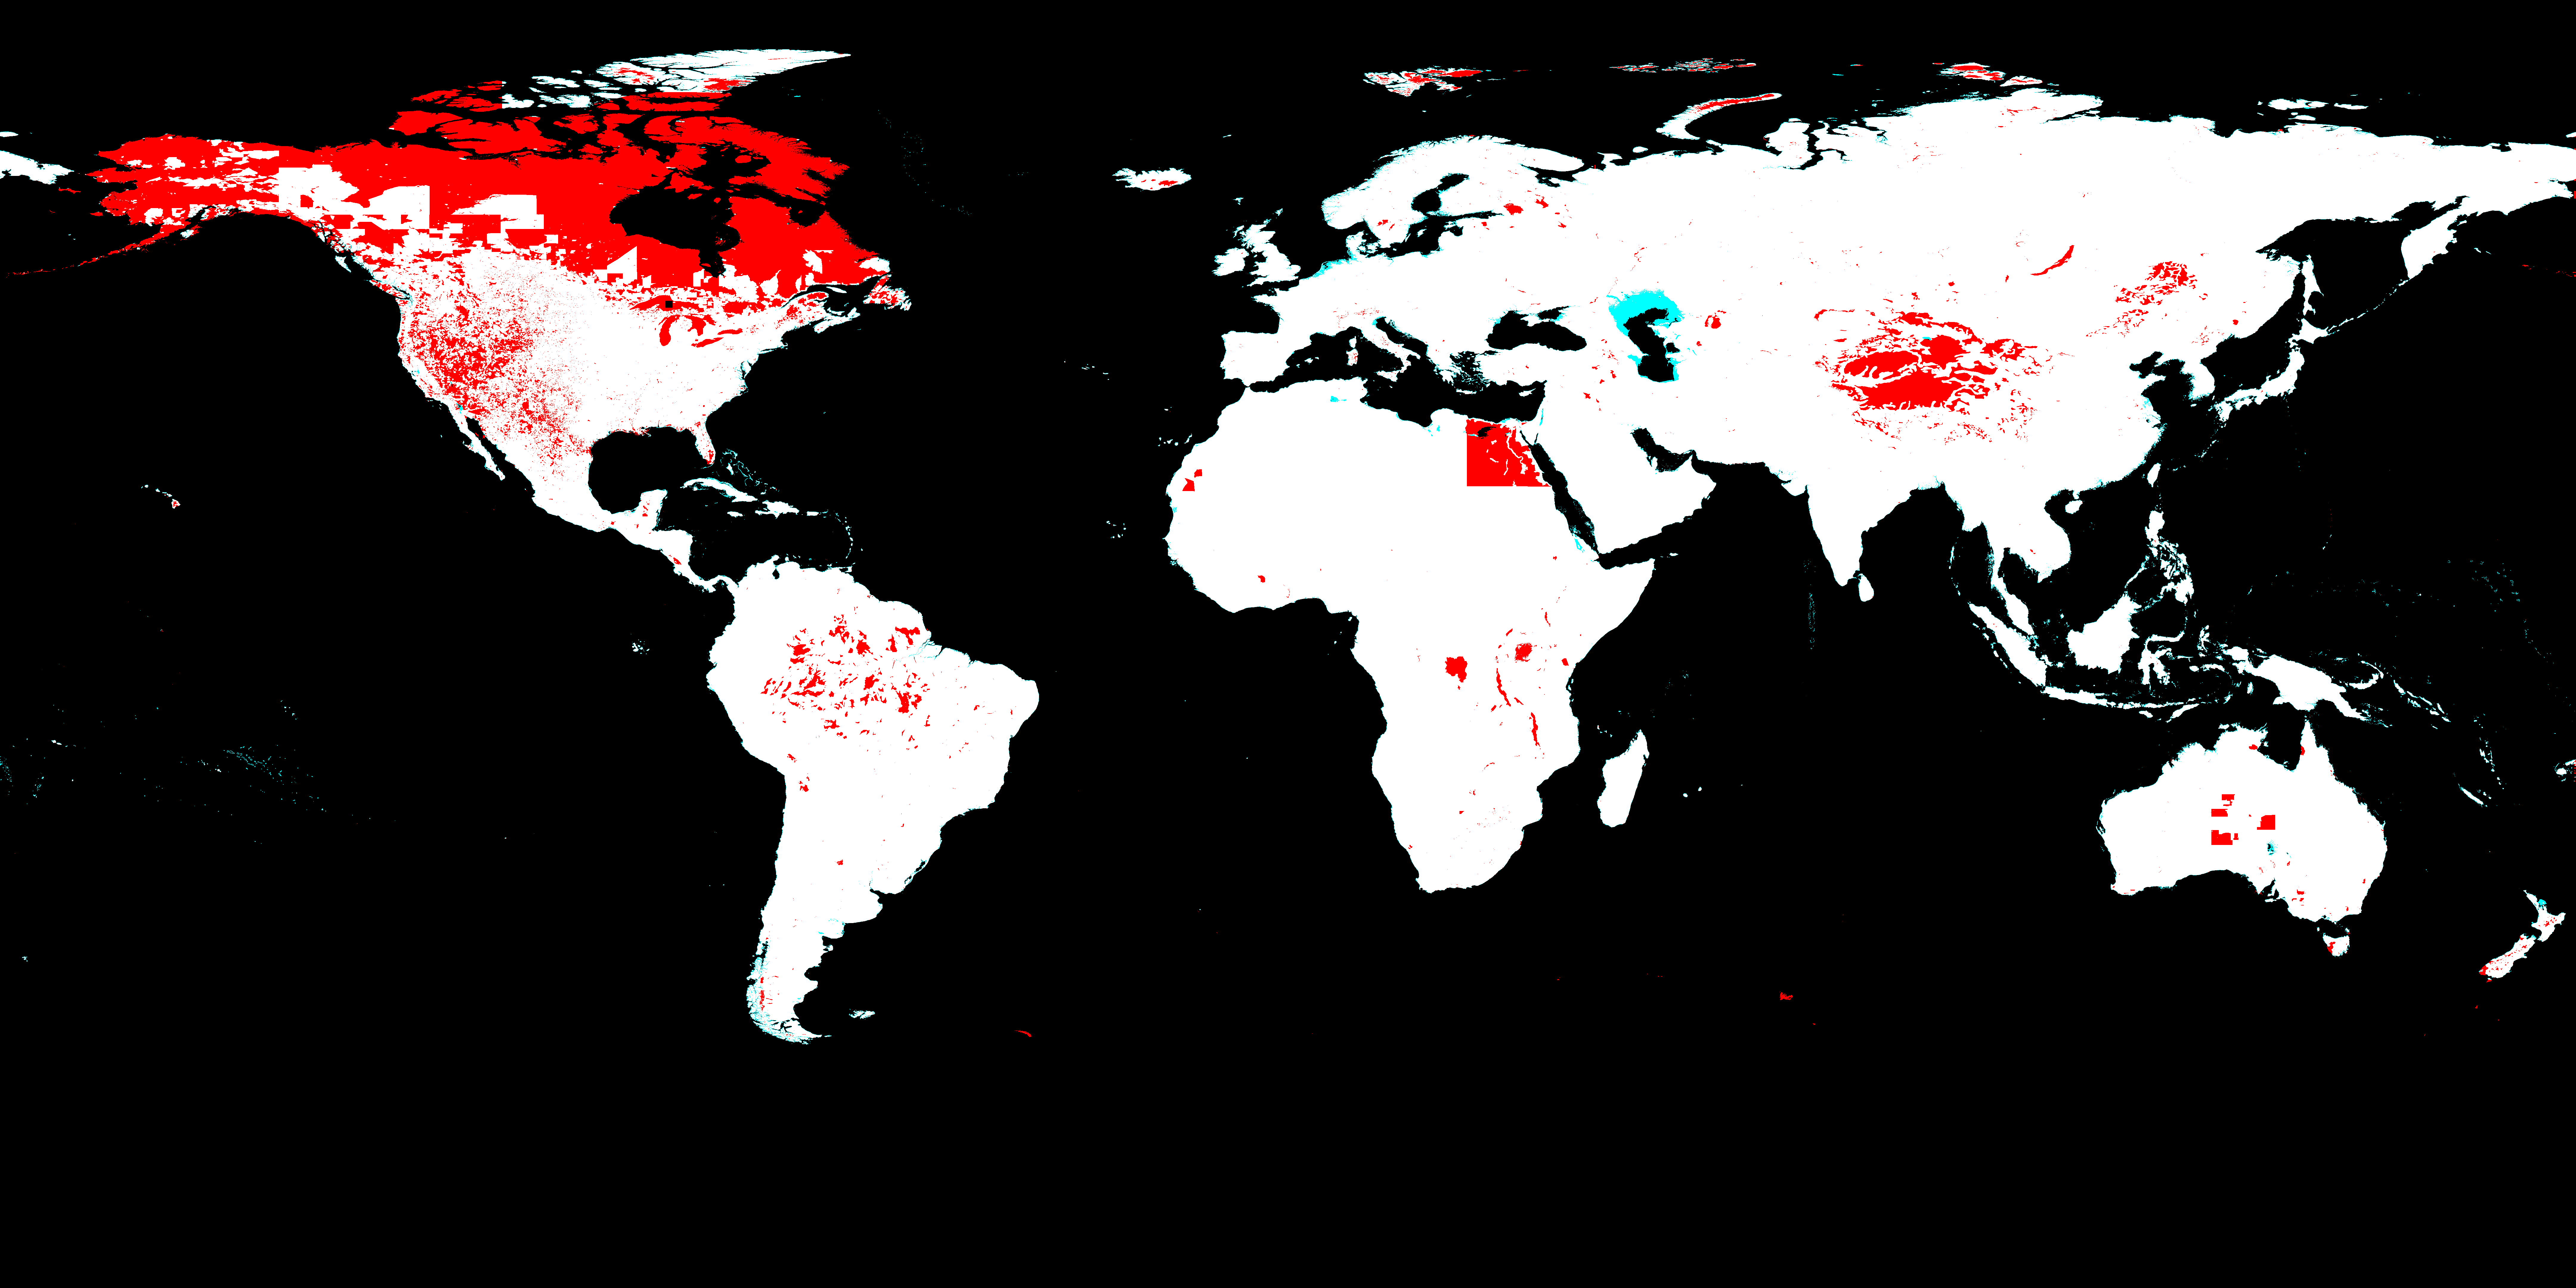

In [15]:
def sample(a):
    return a > 0

img = np.dstack([sample(height_data), sample(pop_data), sample(pop_data)]) * 255
Image.fromarray(img.astype(np.uint8))

### Store as TIFF

Now store the value as a geotiff for later processing

In [16]:
as_tiff = rasterio.open('elevation.tiff', 'w', driver='GTiff',
                        height=pop.height, width=pop.width,
                        count=1, dtype=str(height_data.dtype),
                        crs=pop.crs,
                        transform=pop.transform)

as_tiff.write(height_data, 1)
as_tiff.close()